In [1]:
#Step 01: Sample 500 titles for Manual Sentiment Labelling
# Why this step?
# - Fine-tuning FinBERT requires labeled examples (positive, negative, neutral)
# - Manually labeling all 10,000+ headlines is impractical
# - A sample of ~500 well-labeled titles is enough to fine-tune FinBERT effectively
# - We will later use the fine-tuned model to predict the rest of the dataset

import pandas as pd

#Load the full dataset

df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/esg_sentiment_data_corrected.xlsx')
# Keep only the 'title' column, drop missing titles
df_titles=df[['title']].dropna()

#Randomlysample 500 title for manual labelling

sample_df=df_titles.sample(n=500, random_state=42)

#Add an empty 'label'  column for manual sentiment input : positive / neutral / negative
sample_df['sentiment']=''

#SAVE AS CSV

sample_df.to_csv('/content/drive/MyDrive/Colab Notebooks/esg_sample_for_labeling.csv', index=False)

print("✅ 500 ESG news titles saved to 'esg_sample_for_labeling.csv' for manual labeling.")

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


✅ 500 ESG news titles saved to 'esg_sample_for_labeling.csv' for manual labeling.


In [2]:
!pip install -q transformers datasets scikit-learn

In [3]:
#Step-02:Load the manually labelled dataset
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/esg_labeled_output_final - esg_labeled_output_final.csv')
display(data)

,Title,ESG_Company_Related,Sentiment
0,"Racism endemic at DfID, staff claim",Yes,negative
1,Kerala CM inaugurates The Gender Park Campus a...,No,not_esg
2,Qatar Regulator Unveils Platform To Help Fight...,No,not_esg
3,Scam calls ‘ could surge as coronavirus lockdo...,No,not_esg
4,"Exxon looking to capture carbon, cut costs at ...",Yes,positive
...,...,...,...
494,How Clear Career Paths Strengthen Retention—an...,No,not_esg
495,One Oil Company's Rocky Path to Renewable Energy,Yes,neutral
496,World Bank: Provides $ 465 Million to Expand E...,No,not_esg
497,Investor Alert: Kaplan Fox Investigates Peabod...,Yes,negative


In [4]:
# Step 3: Basic stats and data info

print("Dataset shape:", data.shape)
print("\nSentiment Distribution:\n", data['Sentiment'].value_counts())
print("\nESG Company Related:\n", data['ESG_Company_Related'].value_counts())

Dataset shape: (499, 3)

Sentiment Distribution:
 Sentiment
not_esg     222
positive    141
negative    109
neutral      27
Name: count, dtype: int64

ESG Company Related:
 ESG_Company_Related
Yes    269
No     230
Name: count, dtype: int64


In [5]:
# Lowercase for consistency
data['Sentiment'] = data['Sentiment'].str.lower()
data['ESG_Company_Related'] = data['ESG_Company_Related'].str.lower()

# Check unique labels
print("Unique Sentiment Labels:", data['Sentiment'].unique())
print("Unique ESG Related Labels:", data['ESG_Company_Related'].unique())

Unique Sentiment Labels: ['negative' 'not_esg' 'positive' 'neutral']
Unique ESG Related Labels: ['yes' 'no']


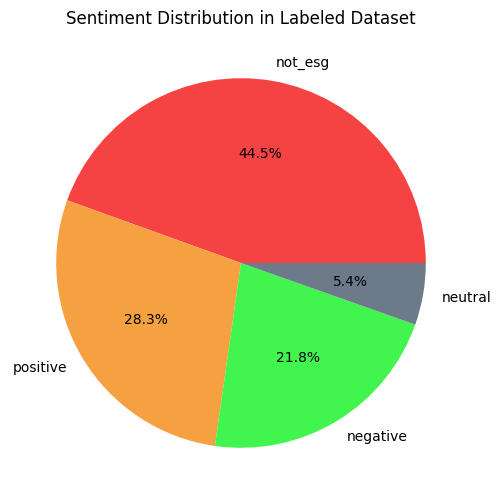

In [6]:
# Step 3: Visualize class distribution (sentiment + ESG flag)
import matplotlib.pyplot as plt
# Pie chart of sentiment labels
sentiment_counts = data['Sentiment'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#f54242', '#f5a142', '#42f54e', '#6c7a89'])
plt.title("Sentiment Distribution in Labeled Dataset")
plt.show()

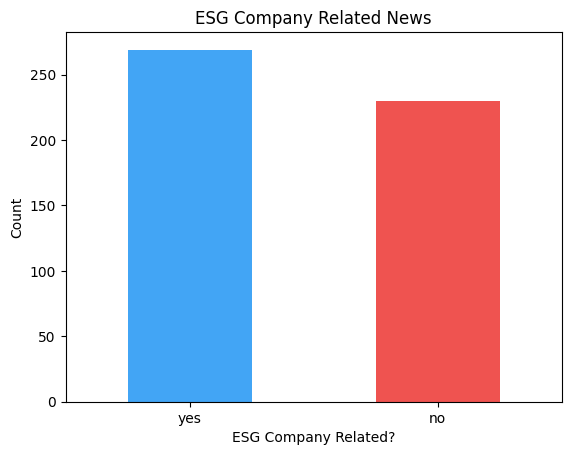

In [7]:
#Step_04:Bar chart of ESG company relevance
esg_counts = data['ESG_Company_Related'].value_counts()
esg_counts.plot(kind='bar', color=['#42a5f5', '#ef5350'])
plt.title("ESG Company Related News")
plt.xlabel("ESG Company Related?")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [8]:
#Step 5: Label Encoding for Sentiment

label_map={'not_esg':0, 'negative':1, 'neutral':2, 'positive':3}

data['label']=data['Sentiment'].map(label_map)

#Preview the data
display(data)

,Title,ESG_Company_Related,Sentiment,label
0,"Racism endemic at DfID, staff claim",yes,negative,1
1,Kerala CM inaugurates The Gender Park Campus a...,no,not_esg,0
2,Qatar Regulator Unveils Platform To Help Fight...,no,not_esg,0
3,Scam calls ‘ could surge as coronavirus lockdo...,no,not_esg,0
4,"Exxon looking to capture carbon, cut costs at ...",yes,positive,3
...,...,...,...,...
494,How Clear Career Paths Strengthen Retention—an...,no,not_esg,0
495,One Oil Company's Rocky Path to Renewable Energy,yes,neutral,2
496,World Bank: Provides $ 465 Million to Expand E...,no,not_esg,0
497,Investor Alert: Kaplan Fox Investigates Peabod...,yes,negative,1


In [9]:
# Load your encoded dataset
data = data.dropna(subset=['Title', 'label'])

# Confirm label distribution
data['label'].value_counts()


,count
label,
0,222
3,141
1,109
2,27


In [10]:
# Step 3: Split Data by Sentiment Class

from sklearn.utils import resample

data_not_esg = data[data['label'] == 0]
data_positive = data[data['label'] == 3]
data_negative = data[data['label'] == 1]
data_neutral = data[data['label'] == 2]

# Step 4: Upsample the Minority Classes to Match the Majority Class Size
target_size = len(data_not_esg)

# Resampling each minority class
df_positive_upsampled = resample(data_positive, replace=True, n_samples=target_size, random_state=42)
df_negative_upsampled = resample(data_negative, replace=True, n_samples=target_size, random_state=42)
df_neutral_upsampled = resample(data_neutral, replace=True, n_samples=target_size, random_state=42)

# Step 5: Combine into a Balanced Dataset
df_balanced = pd.concat([data_not_esg, df_positive_upsampled, df_negative_upsampled, df_neutral_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
# Step 6: Save the Balanced Dataset for Fine-Tuning
df_balanced.to_csv("esg_balanced_sentiment.csv", index=False)
print("✅ Balanced dataset saved with each class size:", target_size)


✅ Balanced dataset saved with each class size: 222


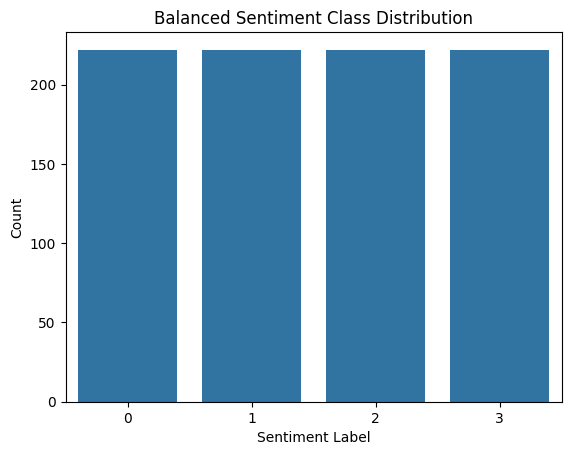

In [12]:
# Step 7: Visualize the Balanced Class Distribution
import seaborn as sns
sns.countplot(data=df_balanced, x='label')
plt.title("Balanced Sentiment Class Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()

In [13]:
#Step 1: Load the CSV into a Pandas DataFrame
import pandas as pd

# Load balanced data
df = pd.read_csv("/content/esg_balanced_sentiment.csv")

# Quick check
df.head()

,Title,ESG_Company_Related,Sentiment,label
0,Piper Sandler Hires Diversity & Inclusion Dire...,yes,positive,3
1,"FDA approves first drug, Eiger's Zokinvy, for ...",yes,positive,3
2,Jihadist mobilization makes Europe vulnerable ...,no,not_esg,0
3,GM to invest $ 1 billion in Mexico for electri...,yes,positive,3
4,"Elanco Animal Health Incorporated: ROSEN, A TR...",yes,negative,1


In [14]:
#Convert to HuggingFace Dataset

from datasets import Dataset

# HuggingFace Dataset
dataset = Dataset.from_pandas(df)



In [15]:
# Split into Train, Validation, and Test Sets
# Split into train+val and test (e.g. 80% train_val, 20% test)

from datasets import DatasetDict
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Then split train_val into train and validation (e.g. 80/20)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)

# Convert all to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [16]:
# Combine into a DatasetDict (Trainer-compatible)
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})


In [17]:
#Step 4: Verify Dataset Structure
print(dataset_dict)
print(dataset_dict['train'][0])


DatasetDict({
    train: Dataset({
        features: ['Title', 'ESG_Company_Related', 'Sentiment', 'label', '__index_level_0__'],
        num_rows: 568
    })
    validation: Dataset({
        features: ['Title', 'ESG_Company_Related', 'Sentiment', 'label', '__index_level_0__'],
        num_rows: 142
    })
    test: Dataset({
        features: ['Title', 'ESG_Company_Related', 'Sentiment', 'label', '__index_level_0__'],
        num_rows: 178
    })
})
{'Title': 'BofA Wants Revived PPP Discrimination Suit Tossed Again', 'ESG_Company_Related': 'yes', 'Sentiment': 'negative', 'label': 1, '__index_level_0__': 673}


In [18]:
#Step 6: Load Tokenizer and Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "yiyanghkust/finbert-tone"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,  # You have 4 classes
    ignore_mismatched_sizes=True  # Important!
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
#Step 7: Tokenize Data
def tokenize(example):
    return tokenizer(example['Title'], padding='max_length', truncation=True, max_length=64)

# Apply tokenizer to each dataset split
tokenized_datasets = dataset_dict.map(tokenize, batched=True)

Map:   0%|          | 0/568 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

In [20]:
#Inspect Tokenized Output
tokenized_datasets["train"][0]

{'Title': 'BofA Wants Revived PPP Discrimination Suit Tossed Again',
 'ESG_Company_Related': 'yes',
 'Sentiment': 'negative',
 'label': 1,
 '__index_level_0__': 673,
 'input_ids': [3,
  9140,
  8635,
  20585,
  10333,
  7161,
  894,
  27943,
  7224,
  23362,
  10344,
  1117,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [21]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [22]:
#Step 8: Define Metrics
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

In [23]:
#Step 9: Define Training Arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./finetuned-esg-sentiment",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    do_train=True,
    do_eval=True,
    logging_steps=50,
    save_steps=100,          # Adjust as needed; older versions need explicit save steps
    save_total_limit=2
)

In [24]:
#Step 10: Train the Model
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zunairat21 (zunairat21-boston-institute-of-analytics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.879300
100,0.303500


TrainOutput(global_step=144, training_loss=0.45150481992297703, metrics={'train_runtime': 115.425, 'train_samples_per_second': 19.684, 'train_steps_per_second': 1.248, 'total_flos': 74724881547264.0, 'train_loss': 0.45150481992297703, 'epoch': 4.0})

In [25]:
trainer.evaluate(tokenized_datasets["test"])


{'eval_loss': 0.27273374795913696,
 'eval_accuracy': 0.9269662921348315,
 'eval_f1': 0.925028673776474,
 'eval_runtime': 0.653,
 'eval_samples_per_second': 272.598,
 'eval_steps_per_second': 9.189,
 'epoch': 4.0}

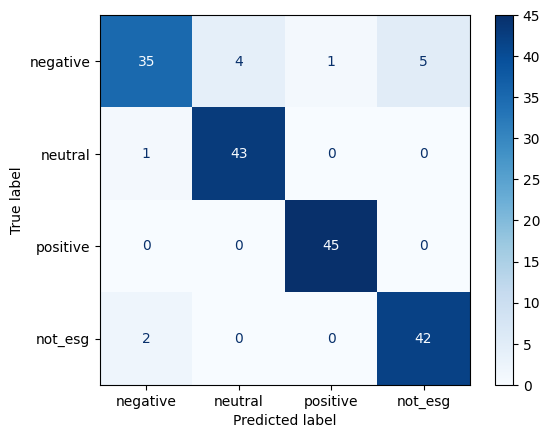

In [26]:
#Plot Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on test set
predictions = trainer.predict(tokenized_datasets["test"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['negative', 'neutral', 'positive', 'not_esg']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")

In [27]:
#Step: Manual Prediction Testing
import torch
from transformers import TextClassificationPipeline

# Create a pipeline using the fine-tuned model
pipeline = TextClassificationPipeline(model=trainer.model, tokenizer=tokenizer, return_all_scores=True, device=0 if torch.cuda.is_available() else -1)

# Label mapping
id2label = {1: "negative", 2: "neutral", 3: "positive", 0: "not_esg"}

# Prediction function
def predict_sentiment(text):
    outputs = pipeline(text)
    scores = outputs[0]
    pred_id = max(scores, key=lambda x: x['score'])['label']
    label_id = int(pred_id.replace("LABEL_", "")) if "LABEL" in pred_id else int(pred_id)
    return id2label[label_id]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [28]:
examples = [
    # ✅ Positive ESG-related
    "Google achieves 100% renewable energy usage across all data centers",
    "Apple introduces new supplier code of conduct to improve labor rights",

    # ❌ Negative ESG-related
    "BP fined $20 million for environmental violations in Alaska",
    "Tesla accused of poor working conditions in Shanghai plant",

    # 🤝 Neutral ESG-related
    "Unilever releases annual ESG performance report for 2024",
    "PepsiCo partners with NGOs to study plastic waste management",

    # 🚫 Not ESG (irrelevant to ESG/company context)
    "Cristiano Ronaldo scores hat-trick in Euro Cup quarterfinal",
    "NASA prepares next moon mission for 2026",

    # 🧾 Ambiguous/mixed context
    "Shell to invest in renewables amid criticism over carbon offsets",
    "Amazon workers protest over lack of climate transparency in reports"
]
for headline in examples:
    print(f"📰 {headline}")
    print(f"👉 Predicted Sentiment: {predict_sentiment(headline)}\n")

📰 Google achieves 100% renewable energy usage across all data centers
👉 Predicted Sentiment: positive

📰 Apple introduces new supplier code of conduct to improve labor rights
👉 Predicted Sentiment: positive

📰 BP fined $20 million for environmental violations in Alaska
👉 Predicted Sentiment: negative

📰 Tesla accused of poor working conditions in Shanghai plant
👉 Predicted Sentiment: not_esg

📰 Unilever releases annual ESG performance report for 2024
👉 Predicted Sentiment: neutral

📰 PepsiCo partners with NGOs to study plastic waste management
👉 Predicted Sentiment: positive

📰 Cristiano Ronaldo scores hat-trick in Euro Cup quarterfinal
👉 Predicted Sentiment: not_esg

📰 NASA prepares next moon mission for 2026
👉 Predicted Sentiment: not_esg

📰 Shell to invest in renewables amid criticism over carbon offsets
👉 Predicted Sentiment: not_esg

📰 Amazon workers protest over lack of climate transparency in reports
👉 Predicted Sentiment: negative



In [29]:
# Create a directory to save your fine-tuned model
save_dir = "finetuned_finbert_esg"

# Save the model and tokenizer
trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('finetuned_finbert_esg/tokenizer_config.json',
 'finetuned_finbert_esg/special_tokens_map.json',
 'finetuned_finbert_esg/vocab.txt',
 'finetuned_finbert_esg/added_tokens.json',
 'finetuned_finbert_esg/tokenizer.json')